In [1]:
import pandas as pd
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt


/users/PCON0041/xiaohu/anaconda3/envs/t5chem/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
# checkpoint should be an OrderedDict type,
# like {'weight': Tensor(...)}
#checkpoint = torch.load("/fs/ess/PCON0041/xiaohu/t5chem/models/uspto500mt/pytorch_model.bin", map_location=torch.device('cpu'))
checkpoint = torch.load("/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/best_model.pkl", map_location=torch.device('cpu'))

size_model = 0
print(checkpoint)
for param in checkpoint.values():
    print(param.shape)
    size_model += param.numel()
    #if param.is_floating_point():
        #size_model += param.numel() * torch.finfo(param.dtype).bits
    #else:
        #size_model += param.numel() * torch.iinfo(param.dtype).bits
print(size_model)
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

OrderedDict([('transformer_r.encoder.layers.0.self_attn.linears.0.weight', tensor([[ 0.1043, -0.0652, -0.0903,  ...,  0.0715,  0.0612, -0.0920],
        [-0.0429,  0.0275,  0.0694,  ...,  0.0868,  0.0290, -0.0070],
        [-0.0663,  0.0170,  0.0476,  ...,  0.0428, -0.1048,  0.0222],
        ...,
        [ 0.0167, -0.0347,  0.0706,  ..., -0.0049, -0.0418, -0.0187],
        [-0.0249, -0.0858,  0.0122,  ...,  0.0253, -0.0735, -0.0941],
        [ 0.0412,  0.0783,  0.0724,  ..., -0.0573, -0.1094,  0.0940]])), ('transformer_r.encoder.layers.0.self_attn.linears.0.bias', tensor([ 0.0479,  0.0473,  0.0336, -0.0203, -0.0261, -0.0041,  0.0464,  0.0622,
        -0.0196, -0.0151,  0.0171,  0.0514, -0.0483, -0.0077,  0.0537, -0.0297,
         0.0137,  0.0577,  0.0401, -0.0618, -0.0491,  0.0123, -0.0280,  0.0515,
         0.0084, -0.0039,  0.0337,  0.0590,  0.0717, -0.0404,  0.0588,  0.0640,
         0.0311,  0.0636, -0.0395, -0.0220, -0.0587, -0.0606, -0.0534, -0.0137,
        -0.0537,  0.0080,  0.

In [3]:
df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/t5chem_results/uspto500mt/predictions_uspto.csv')
print(df1.shape)
#df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/t5chem/models/test/predictions.csv')
t5target = df1['target'] / 100
t5pred = df1['prediction'] / 100
print(t5pred.shape)

ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) 
label = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv')['label'].values
data = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv') 
ourtarget = data['yield'].values / 100
data_ori = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/test.csv') 
label_unique = data['label'].unique()
temp = []
sep_data = []

for i in label_unique:
    sep_data.append(data[data["label"] == i])
    template = data_ori[data_ori['labels']==i]['retro_template'].values[0]
    #print(template)
    temp.append(template)


(9497, 2)
(9497,)


In [4]:
ourpred_w = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/wmodels/result.pt',map_location=torch.device('cpu'))[:,0]) 


In [5]:
import numpy as np

t5abs_err = np.abs(t5target - t5pred) 
#t5abs_err = t5target - t5pred
t5mae = np.mean(np.abs(t5target - t5pred))
print("t5 Mean Absolute Error:", t5mae)

print(ourpred.shape)
print(t5target.shape)
ourabs_err = np.abs(ourtarget - ourpred)
#ourabs_err = ourtarget - ourpred 
ourmae = np.mean(np.abs(ourtarget - ourpred))
print("Our Mean Absolute Error:", ourmae)

ourabs_err_w = np.abs(ourtarget - ourpred_w)
#ourabs_err_w = ourtarget - ourpred_w
ourmae_w = np.mean(np.abs(ourtarget - ourpred_w))
print("Our Mean Absolute Error:", ourmae_w)

t5 Mean Absolute Error: 0.1896369333299134
(9497,)
(9497,)
Our Mean Absolute Error: 0.1805947884004518
Our Mean Absolute Error: 0.1786794919348383


In [6]:
import scipy.stats
#print(scipy.stats.ttest_ind(ourabs_err_w, ourabs_err, equal_var=False))
print(scipy.stats.ttest_rel(ourabs_err_w, t5abs_err))
print(scipy.stats.ttest_rel(ourabs_err, t5abs_err))
print(scipy.stats.ttest_rel(ourabs_err_w, ourabs_err))

Ttest_relResult(statistic=-6.927924586016691, pvalue=4.548032346084463e-12)
Ttest_relResult(statistic=-5.682519054355359, pvalue=1.366394573324133e-08)
Ttest_relResult(statistic=-2.1835411757712047, pvalue=0.02902037142381342)


# reaction templates

In [7]:
unique_temp = label_unique
better_label = []
better_temp = []
worse_label = []
worse_temp = []
equal_label = []
equal_temp = []
d = unique_temp.shape[0]
our_mae = np.zeros((d,1))
t5_mae = np.zeros((d,1))
print(unique_temp.shape)
for i in range(len(unique_temp)):
    index = np.where(label==unique_temp[i])[0]
    our_mae[i][0] = np.mean(ourabs_err[index])
    t5_mae[i][0] = np.mean(t5abs_err[index])
    if np.mean(ourabs_err[index]) < np.mean(t5abs_err[index]):
        better_label.append(unique_temp[i])
        better_temp.append(temp[i])
    elif np.mean(ourabs_err[index]) > np.mean(t5abs_err[index]):
        worse_label.append(unique_temp[i])
        worse_temp.append(temp[i])
    else:
        equal_label.append(unique_temp[i])
        equal_temp.append(temp[i]) 
print(len(better_temp), len(worse_temp))

(412,)
246 166


In [8]:
## https://github.com/AstraZeneca/molecular-complexity/tree/main
"""
This is the code to calculate the CM, CM_star and Cse metrics.
"""
from collections import Counter
from typing import Dict, Iterator, List, NamedTuple, Tuple

import numpy as np
from rdkit import Chem

# Atom types are defined as (symbol, total degree, non-h degree)
AtomType = Tuple[str, int, int]
# Atoms are defined as (atom index, atom type)
Atom = Tuple[int, AtomType]
AtomDict = Dict[Atom, List[Atom]]


class MolecularComplexity(NamedTuple):
    cm: float
    cm_star: float
    cse: float


def _non_h_items(data: Dict[Atom, any]) -> Iterator[Tuple[Atom, any]]:
    """
    Generator for non-H items from a dictionary where the keys are atom tuples.
    """
    for key, val in data.items():
        if key[1][0] != "H":
            yield key, val


def _collect_atom_paths(neighbors: AtomDict) -> List[List[tuple]]:
    """
    Returns list of atom paths for each atom.

    An atom path is a tuple of atom types.
    """
    atom_paths = []
    for atom, nbs in _non_h_items(neighbors):
        paths = []
        for nb in nbs:
            if nb[1][0] == "H" or neighbors[nb] == [atom]:
                # No second neighbors
                paths.append((atom[1], nb[1]))
            else:
                paths.extend(
                    (atom[1], nb[1], nb2[1]) for nb2 in neighbors[nb] if nb2 != atom
                )

        atom_paths.append(paths)

    return atom_paths


def get_atom_type(atom: Chem.rdchem.Mol) -> AtomType:
    """
    Return a tuple describing the atom type.

    Considers element, total number of connections, and number of non-H connections.
    """
    symbol = atom.GetSymbol()
    degree = atom.GetTotalDegree()
    h_count = atom.GetTotalNumHs(includeNeighbors=True)
    non_h = degree - h_count
    return (symbol, degree, non_h)


def fractional_occurrence(data: list) -> np.ndarray:
    """
    Calculate the fractional occurrence of unique items in the input data.

    Uniqueness determined by collections.Counter.

    Returns:
        np.ndarray: fractional occurrence of unique items
    """
    counter = Counter(data)
    counts = np.array(list(counter.values()))
    return counts / len(data)


def calculate_molecular_complexity(mol: Chem.rdchem.Mol) -> MolecularComplexity:
    """
    This is a function to calculate the molecular complexity metrics described in
    Proudfoot, Bioorganic & Medicinal Chemistry Letters 27 (2017) 2014-2017.
    https://doi.org/10.1016/j.bmcl.2017.03.008

    This function takes an RDKit Mol object, enumerates atom paths,
    and then calculates the complexity environment for each atom CA as

    CA = - Sum (pi*log2(pi)) + log2(N)

    where pi is the fractional occurrence of each path type emanating from
    an atom and N is the total number of paths emanating from that atom.

    Molecular complexity CM can be defined as either the simple sum of the CA,
    or CM* which is the log-sum of the exponentials of the CA.

    CM = Sum (CA)

    CM* = log2(Sum (2**CA))

    Cse = - Sum (qi*log2(qi))

    where qi is the fractional occurrence of an atom environment.
    """
    # get atom types for each atom in the molecule
    atoms = [(atom.GetIdx(), get_atom_type(atom)) for atom in mol.GetAtoms()]

    # create dict with neighbors of each atom
    neighbors = {
        atom: [
            atoms[neighbor.GetIdx()]
            for neighbor in mol.GetAtomWithIdx(atom[0]).GetNeighbors()
        ]
        for atom in atoms
    }

    atom_paths = _collect_atom_paths(neighbors)

    cas = np.zeros(len(atom_paths))
    for i, paths in enumerate(atom_paths):
        total_paths = len(paths)
        pi = fractional_occurrence(paths)
        cas[i] = -np.sum(pi * np.log2(pi)) + np.log2(total_paths)

    cm = np.sum(cas)

    cm_star = np.log2(np.sum(2**cas))

    # sort and concatenate the individual paths to compare the atom environments
    atom_environments = [tuple(sorted(paths)) for paths in atom_paths]

    # Now we can calculate the Cse metric as the fractional occurrence of each atom environment
    qi = fractional_occurrence(atom_environments)
    cse = -np.sum(qi * np.log2(qi))

    #return MolecularComplexity(cm, cm_star, cse)
    return cm


def molecular_complexity(smiles: str) -> MolecularComplexity:
    """This function takes SMILES and returns the CM, CM*, and Cse metrics"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        return calculate_molecular_complexity(mol)
    except Exception:
        return MolecularComplexity(np.nan, np.nan, np.nan)

# Yield ranges

1.4812774415505408e-10 0.10446786256684443
2.401054939287913e-17 0.09496559815820033
1.5423887296124242e-10 0.05074721930597148
1.418232052581421e-06 0.031851724879019605
4.78863880818016e-05 -0.01971294320877176
3.0360207341259863e-12 -0.030035607422315064
7.057308949979322e-40 -0.048451362361258646
3.2848227460385014e-40 -0.050135664906791055
6.209482247085506e-08 -0.021042540594389397
0.034850960239734316 0.007505174941911497


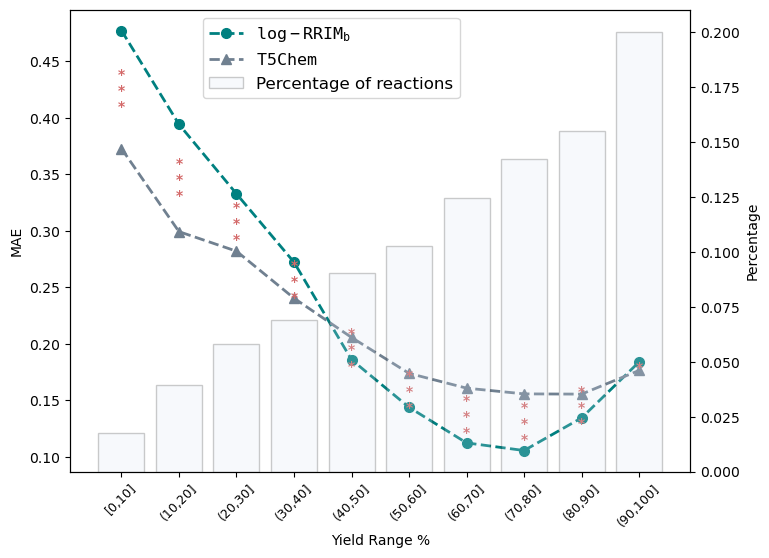

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
#plt.rcParams.update({
#    "text.usetex": True,
    #"font.family": 'Times New Roman'
#})
plt.rcParams['font.size'] = 10
# Example data initialization (replace with your actual data)
our_color = '#008080'
t5_color = '#708090'
back_color = '#D9E4F1'
yield_range = np.array([[-1, 10], [10, 20], [20, 30], [30, 40], [40, 50], [50, 60], [60, 70], [70, 80], [80, 90], [90, 100]]) / 100
d = yield_range.shape[0]
our_grid_mae = np.zeros((d,1))
our_grid_mae_w = np.zeros((d,1))
t5_grid_mae = np.zeros((d,1))
our_grid_mae_std = np.zeros((d))
t5_grid_mae_std = np.zeros((d))
amount = np.zeros((d,1))
x = np.arange(d)
p_values = np.zeros(d)

# Sample data (replace with actual data processing code)
for i in range(d):
    index1 = np.where(t5target > yield_range[i][0])[0]
    index2 = np.where(t5target <= yield_range[i][1])[0]    
    intersect_index = list(set(index1) & set(index2))
    our_grid_mae[i][0] = np.mean(ourabs_err[intersect_index])
    our_grid_mae_w[i][0] = np.mean(ourabs_err_w[intersect_index])
    t5_grid_mae[i][0] = np.mean(t5abs_err[intersect_index])
    our_grid_mae_std[i] = np.std(ourabs_err[intersect_index])
    t5_grid_mae_std[i] = np.std(t5abs_err[intersect_index])
    amount[i][0] = len(intersect_index)

    p_values[i] = scipy.stats.ttest_rel(ourabs_err[intersect_index], t5abs_err[intersect_index])[1]
    print(p_values[i], our_grid_mae[i][0]-t5_grid_mae[i][0])

our_grid_mae = our_grid_mae.reshape(-1)
our_grid_mae_w = our_grid_mae_w.reshape(-1)
t5_grid_mae = t5_grid_mae.reshape(-1)

    

# Plotting
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

# Bar plot
bar = ax2.bar(x, amount.flatten() / amount.sum(), color=back_color, edgecolor='black', alpha=0.2, label='Percentage of reactions')

# Line plots
line1, = ax1.plot(x, our_grid_mae, color=our_color, linestyle='--', linewidth=2, marker='o', ms=7, label='$\mathtt{log-RRIM_{b}}$')
line2, = ax1.plot(x, t5_grid_mae, color=t5_color, linestyle='--', linewidth=2, marker='^', ms=7, label='$\mathtt{T5Chem}$')

# Combined legend
lines = [line1, line2, bar]
labels = [line1.get_label(), line2.get_label(), bar.get_label()]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.2, 1.0), fontsize=12)

# Setting labels and ticks
ax1.set_xticks(x)
ax1.set_xticklabels(['[0,10]', '(10,20]', '(20,30]', '(30,40]', '(40,50]', '(50,60]', '(60,70]', '(70,80]', '(80,90]', '(90,100]'], fontsize=9, rotation=45)
ax1.set_ylabel('MAE')
ax1.set_xlabel('Yield Range %')

# Additional settings for the bar plot axis
ax2.set_ylabel('Percentage')

# Significance annotation for legend
#import matplotlib.lines as mlines
#star = mlines.scatter([], [], color='none', marker='*', markersize=10, label='Significance (p < 0.05)', markerfacecolor='#C85050', linestyle='None')

# Combine all legends into one
#ax1.legend(handles=lines + [star], labels=labels + [star.get_label()], loc='upper left', bbox_to_anchor=(0.2, 1.0), fontsize=12)

# Add significance annotations
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
# Add significance annotations with vertical stacking of asterisks
for i in range(d):
    if p_values[i] < 0.0005:  # Highly significant
        ax1.annotate('*\n*\n*', (x[i], 1/2 * (our_grid_mae[i] + t5_grid_mae[i]) - 0.019), fontsize=10, ha='center', color='#D46A6A', weight='bold')
    elif p_values[i] < 0.005:  # Very significant
        ax1.annotate('*\n*', (x[i], 1/2 * (our_grid_mae[i]+t5_grid_mae[i]) - 0.01), fontsize=10, ha='center', color='#D46A6A', weight='bold')
    elif p_values[i] < 0.05:  # Significant
        ax1.annotate('*', (x[i], 1/2 * (our_grid_mae[i] + t5_grid_mae[i]) - 0.005), fontsize=10, ha='center', color='#D46A6A', weight='bold')



plt.show()


[0.9 1. ] 0.007648087381230675
0.02799030285390166
[0.8 1. ] -0.005800772357402842
0.026035270463914514
[0.7 1. ] -0.01823130615449939
3.794219759236736e-17
[0.6 1. ] -0.02404876287566902
3.0662463705222776e-37
[0.5 1. ] -0.024731906605035204
1.6062980572322224e-46
[0.4 1. ] -0.02431693030407708
3.0503001280783886e-50
[0.3 1. ] -0.019717214845750636
4.474761326035972e-35
[0.2 1. ] -0.015477468179774604
1.4267934492475233e-22
[0.1 1. ] -0.011034322920244442
3.951391985814504e-12
[-0.01  1.  ] -0.00904214492946082
1.366394573324133e-08


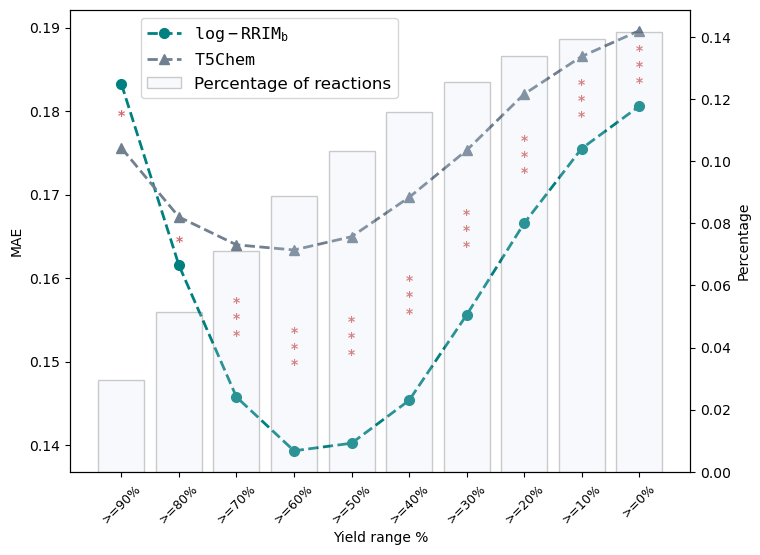

In [10]:
import scipy.stats
#plt.rcParams.update({
#    "text.usetex": True,
#    #"font.family": 'Times New Roman'
#})
plt.rcParams['font.size'] = 10
n_reactions = t5target.shape[0]
yield_range = np.array([[90, 100], [80, 100], [70, 100], [60, 100], [50, 100], [40, 100], [30, 100], [20, 100], [10, 100], [-1, 100]]) / 100
d = yield_range.shape[0]
our_grid_mae = np.zeros((d,1))
t5_grid_mae = np.zeros((d,1))
our_grid_mae_std = np.zeros((d))
t5_grid_mae_std = np.zeros((d))
amount = np.zeros((d,1))
x = np.arange(d)
p_values = np.zeros(d)
for i in range(d):
    index1 = np.where(t5target>=yield_range[i][0])[0]
    index2 = np.where(t5target<=yield_range[i][1])[0]    
    intersect_index = list(set(index1) & set(index2))
    #print()
    #

    print(yield_range[i], np.mean(ourabs_err[intersect_index]-t5abs_err[intersect_index]))
    #print(scipy.stats.ttest_rel(ourabs_err[intersect_index], t5abs_err[intersect_index]))

    our_grid_mae[i][0] = np.mean(ourabs_err[intersect_index])
    t5_grid_mae[i][0] = np.mean(t5abs_err[intersect_index])

    our_grid_mae_std[i] = np.std(ourabs_err[intersect_index])
    our_grid_mae_std[i] = np.std(ourabs_err[intersect_index])

    t5_grid_mae_std[i] = np.std(t5abs_err[intersect_index])
    t5_grid_mae_std[i] = np.std(t5abs_err[intersect_index])
    amount[i][0] = len(intersect_index)

    p_values[i] = scipy.stats.ttest_rel(ourabs_err[intersect_index], t5abs_err[intersect_index])[1]
    print(p_values[i])

our_grid_mae = our_grid_mae.reshape(-1)
our_grid_mae_w = our_grid_mae_w.reshape(-1)
t5_grid_mae = t5_grid_mae.reshape(-1)


fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

# Bar plot
bar = ax2.bar(x, amount.flatten() / amount.sum(), color=back_color, edgecolor='black', alpha=0.2, label='Percentage of reactions')

# Line plots
line1, = ax1.plot(x, our_grid_mae, color=our_color, linestyle='--', linewidth=2, marker='o', ms=7, label='$\mathtt{log-RRIM_{b}}$')
line2, = ax1.plot(x, t5_grid_mae, color=t5_color, linestyle='--', linewidth=2, marker='^', ms=7, label='$\mathtt{T5Chem}$')

# Combined legend
lines = [line1, line2, bar]
labels = [line1.get_label(), line2.get_label(), bar.get_label()]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 1.0),fontsize=12)

ax1.set_xticks(x, ['>=90%', '>=80%', '>=70%', '>=60%', '>=50%', '>=40%', '>=30%', '>=20%', '>=10%', '>=0%'], fontsize=9, rotation=45)
#ax1.legend(['our model', 't5chem'])
ax1.set_ylabel('MAE')
ax2.set_ylabel('Percentage')
ax1.set_xlabel('Yield range %')
#ax1.grid()

for i in range(d):
    if p_values[i] < 0.0005:  # Highly significant
        ax1.annotate('*\n*\n*', (x[i], 1/2 * (our_grid_mae[i] + t5_grid_mae[i]) - 0.0022), fontsize=10, ha='center',color='#D46A6A', weight='bold')
    elif p_values[i] < 0.005:  # Very significant
        ax1.annotate('*\n*', (x[i], 1/2 * (our_grid_mae[i]+t5_grid_mae[i]) - 0.001), fontsize=10, ha='center', color='#D46A6A', weight='bold')
    elif p_values[i] < 0.05:  # Significant``````````
        ax1.annotate('*', (x[i], 1/2 * (our_grid_mae[i] + t5_grid_mae[i]) - 0.0005), fontsize=10, ha='center',color='#D46A6A', weight='bold')

In [11]:
df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/t5chem_results/uspto500mt/predictions_uspto.csv')
t5target = df1['target'].values
t5pred = df1['prediction'].values

ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) * 100
label = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv')['label'].values
data = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/USPTO500MT_test_processed_100.csv')
data_ori = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/Data/USPTO/test.csv')
label_unique = data['label'].unique()
temp = []
sep_data = []

for i in label_unique:
    sep_data.append(data[data["label"] == i])
    template = data_ori[data_ori['labels']==i]['retro_template'].values[0]
    print(template)
    temp.append(template)


([C:1]-[CH;D3;+0:2](-[C:3])-[OH;D1;+0:4])>>([C:1]-[C;H0;D3;+0:2](-[C:3])=[O;H0;D1;+0:4])
([C:4]-[N;H0;D3;+0:5](-[C:6])-[c;H0;D3;+0:1](:[c:2]):[c:3])>>(Br-[c;H0;D3;+0:1](:[c:2]):[c:3]).([C:4]-[NH;D2;+0:5]-[C:6])
([C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](=[O;D1;H0:2])(=[O;D1;H0:3])-[c:4])>>(Cl-[S;H0;D4;+0:1](=[O;D1;H0:2])(=[O;D1;H0:3])-[c:4]).([C:5]-[OH;D1;+0:6])
([C:2]-[C;H0;D3;+0:1](-[c:3])=[N;H0;D2;+0:4]-[O;D1;H1:5])>>(O=[C;H0;D3;+0:1](-[C:2])-[c:3]).([NH2;D1;+0:4]-[O;D1;H1:5])
([C:4]-[N;H0;D3;+0:5](-[C:6])-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3])>>(O-[C;H0;D3;+0:1](-[C:2])=[O;D1;H0:3]).([C:4]-[NH;D2;+0:5]-[C:6])
([C:1]-[CH;D2;+0:2]=[O;H0;D1;+0:3])>>([C:1]-[CH2;D2;+0:2]-[OH;D1;+0:3])
([#7;a:4]:[c:3]-[C;H0;D3;+0:1](=[O;D1;H0:2])-[NH;D2;+0:6]-[C:5])>>(O-[C;H0;D3;+0:1](=[O;D1;H0:2])-[c:3]:[#7;a:4]).([C:5]-[NH2;D1;+0:6])
([C:4]-[O;H0;D2;+0:5]-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3])>>(C-C(=O)-O-[C;H0;D3;+0:1](-[C;D1;H3:2])=[O;D1;H0:3]).([C:4]-[OH;D1;+0:5])
([C:2]-[CH2;D2;+0:1]-[O;H0;D2;+0:3]-[c:4]

In [12]:
r = []
a = []
p = []
target_value = []
t5_value = []
our_value = []
label_value = []
judge = 'reactants'
for i in range(len(label_unique)):
    label = label_unique[i]
    temp_data = sep_data[i]
    l = sep_data[i].shape[0]
    r_unique, r_unique_count = np.unique(temp_data[judge].values, return_counts=True)
    if len(r_unique) < l:
        print('%d template, has %d reactions, %d reagents are unique'%(label, l, len(r_unique)))
        r_select = r_unique[np.where(r_unique_count>=2)[0]]
        for k in r_select:
            index1 = np.where(data['label'].values==label)[0]
            index2 = np.where(temp_data[judge].values==k)[0]

            target = t5target[index1][index2]
            t5 = t5pred[index1][index2]
            our = ourpred[index1][index2]

            print(temp_data['reactants'].values[index2], temp_data['reagents'].values[index2], temp_data['products'].values[index2],)
            for n in range(len(index2)):
                r.append(temp_data['reactants'].values[index2[n]])
                a.append(temp_data['reagents'].values[index2[n]])
                p.append(temp_data['products'].values[index2[n]])
                target_value.append(target[n])
                t5_value.append(t5[n])
                our_value.append(our[n])
                label_value.append(label) 

34 template, has 78 reactions, 75 reagents are unique
['COCCOCCO.Cc1ccc(S(=O)(=O)Cl)cc1' 'COCCOCCO.Cc1ccc(S(=O)(=O)Cl)cc1'] ['C1CCOC1.O.[Na+].[OH-]' 'O.c1ccncc1'] ['COCCOCCOS(=O)(=O)c1ccc(C)cc1' 'COCCOCCOS(=O)(=O)c1ccc(C)cc1']
['Cc1ccc(S(=O)(=O)Cl)cc1.OCC1CCOC1' 'Cc1ccc(S(=O)(=O)Cl)cc1.OCC1CCOC1'] ['C1CCOC1.CCN(CC)CC' 'ClCCl.O.c1ccncc1'] ['Cc1ccc(S(=O)(=O)OCC2CCOC2)cc1' 'Cc1ccc(S(=O)(=O)OCC2CCOC2)cc1']
['Cc1ccc(S(=O)(=O)Cl)cc1.OCC1COc2ccccc2O1'
 'Cc1ccc(S(=O)(=O)Cl)cc1.OCC1COc2ccccc2O1'] ['CCN(CC)CC.ClCCl' 'Cl.c1ccncc1'] ['Cc1ccc(S(=O)(=O)OCC2COc3ccccc3O2)cc1'
 'Cc1ccc(S(=O)(=O)OCC2COc3ccccc3O2)cc1']
25 template, has 73 reactions, 72 reagents are unique
['CN(CCO)C(=O)OC(C)(C)C' 'CN(CCO)C(=O)OC(C)(C)C'] ['CC(=O)OI1(OC(C)=O)(OC(C)=O)OC(=O)c2ccccc21.ClCCl.O=C([O-])O.O=S([O-])([O-])=S.[Na+].[Na+].[Na+]'
 'CCN(CC)CC.CO.CS(C)=O.ClCCl.O=S(=O)=O.c1ccncc1'] ['CN(CC=O)C(=O)OC(C)(C)C' 'CN(CC=O)C(=O)OC(C)(C)C']
108 template, has 34 reactions, 33 reagents are unique
['CN.O=C(O)c1ccc(Br)cn1' 'CN.O=C

In [13]:
same_reactants = pd.DataFrame({'r':r, 'a':a, 'p':p, 'target':target_value, 't5':t5_value, 'Our':our_value, 'label': label_value})

In [14]:
same_reactants.head(3)
same_reactants.to_csv('same_reactants.csv')

# Reactant same

In [16]:
import numpy as np
import pandas as pd
import torch
df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/MAT/t5chem_results/uspto500mt/predictions_uspto.csv')
t5target = df1['target'].values 
t5pred = df1['prediction'].values 
ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) 
data = pd.read_csv('same_reactants.csv')
unique_reactant = np.unique(data['r'].values)
target_diff = []
t5_diff = []
our_diff = []
t5mae = []
ourmae = []
def calculate_all_differences(vector):
    differences = []
    n = len(vector)
    for i in range(n):
        for j in range(i+1, n):
            diff = vector[j] - vector[i]
            differences.append(diff)
    return differences


for i in unique_reactant:
    #print(i)
    index = np.where(data['r'].values==i)[0]
    target = data['target'].values[index] / 100
    t5 = data['t5'].values[index] / 100
    our = data['Our'].values[index] / 100

    #t5mae = np.abs(t5-target)
    #ourmae = np.abs(our-target)
    t5mae.append(np.mean(np.abs(t5-target)))
    ourmae.append(np.mean(np.abs(our-target)))
    #if((np.mean(t5mae)<=1) & (np.mean(ourmae)<=1)):
    #print(i, t5mae, ourmae)
    target_diff.extend(calculate_all_differences(target))
    t5_diff.extend(calculate_all_differences(t5))
    our_diff.extend(calculate_all_differences(our))


#plt.legend(['Our method', 't5'])

In [17]:
t5mae = np.array(t5mae)
ourmae = np.array(ourmae)
print(np.mean(t5mae), np.mean(ourmae))

0.18219295351662568 0.14490497843654015


In [18]:
our_diff = np.array(our_diff)
t5_diff = np.array(t5_diff)
target_diff = np.array(target_diff)
index = np.where(np.abs(our_diff - target_diff) <= np.abs(t5_diff-target_diff))[0]
print(len(index),len(target_diff))

47 76


/tmp/ipykernel_8075/2309238093.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(target_diff[i],our_diff[i],c=colormaps(i%10),marker = markers[i%10],alpha=1)
/tmp/ipykernel_8075/2309238093.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(target_diff[i],t5_diff[i],c=colormaps(i%10),marker = markers[i%10],alpha=1)


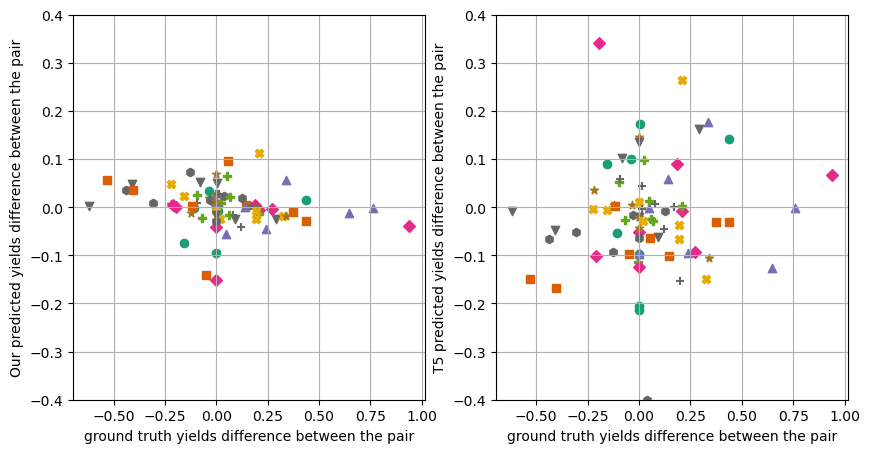

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10,5))
colormaps = plt.cm.Dark2  # You can choose any qualitative colormap
markers = ['o', 's', '^', 'D', 'P', 'X', '*', '+', 'v', 'h']
for i in range(len(target_diff)):
    axes[0].scatter(target_diff[i],our_diff[i],c=colormaps(i%10),marker = markers[i%10],alpha=1)
axes[0].grid('ON')
axes[0].set_xlabel('ground truth yields difference between the pair')
axes[0].set_ylabel('Our predicted yields difference between the pair')
axes[0].set_ylim((-0.4,0.4))
fig2 = plt.figure()
for i in range(len(target_diff)):
    #plt.scatter(target_diff[i],our_diff[i],c='green',marker='o',alpha=0.5)
    axes[1].scatter(target_diff[i],t5_diff[i],c=colormaps(i%10),marker = markers[i%10],alpha=1)
axes[1].grid('ON')
axes[1].set_xlabel('ground truth yields difference between the pair')
axes[1].set_ylabel('T5 predicted yields difference between the pair')
axes[1].set_ylim((-0.4,0.4))
plt.tight_layout()

In [21]:
import numpy as np
import pandas as pd
import torch
import scipy
df1 = pd.read_csv('/fs/ess/PCON0041/xiaohu/t5chem/models/uspto500mt/predictions.csv')
t5target = df1['target'].values
t5pred = df1['prediction'].values
ourpred = np.array(torch.load('/fs/ess/PCON0041/xiaohu/MAT/results/final/uspto_new_wsigmoid/womodels/result.pt',map_location=torch.device('cpu'))[:,0]) * 100
data = pd.read_csv('same_reactants.csv')
unique_reactant = np.unique(data['r'].values)
target_diff = []
t5_diff = []
our_diff = []

def calculate_all_differences(vector):
    differences = []
    n = len(vector)
    for i in range(n):
        for j in range(i+1, n):
            diff = vector[j] - vector[i]
            differences.append(diff)
    return differences


for i in unique_reactant:
    #print(i)
    index = np.where(data['r'].values==i)[0]
    target = data['target'].values[index]
    t5 = data['t5'].values[index]
    our = data['Our'].values[index]
    
    target_diff.extend(calculate_all_differences(target))
    t5_diff.extend(calculate_all_differences(t5))
    our_diff.extend(calculate_all_differences(our))




In [22]:
from scipy import stats
res_our = stats.pearsonr(target_diff, our_diff)
print(res_our)
res_t5 = stats.pearsonr(target_diff, t5_diff)
print(res_t5)
print(scipy.stats.ttest_ind(our_diff, t5_diff))
#res_our_t5 = stats.pearsonr(our_diff, t5_diff)
#print(res_our_t5)
#print(len(our_diff))
#res_our = stats.spearmanr(target_diff, our_diff)
#print(res_our)
#res_t5 = stats.spearmanr(target_diff, t5_diff)
#print(res_t5)

(-0.19123372113888998, 0.09796145494847543)
(0.08777418737435552, 0.4508655896518422)
Ttest_indResult(statistic=1.4314983206030147, pvalue=0.15436771939266525)


78.0 73.10527038574219 69.31546020507812


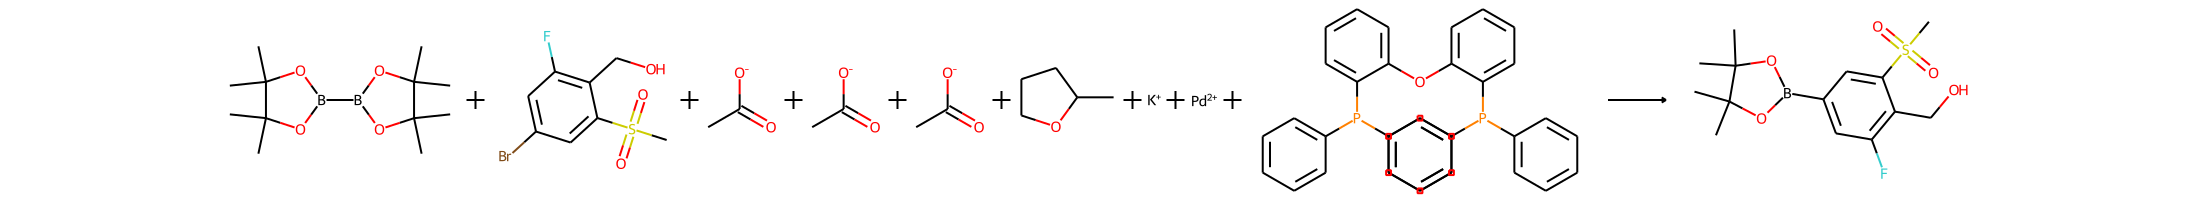

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image
data = pd.read_csv('same_reactants.csv')
index = [90,91]
#index = [24,25]
smiles0 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles1 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn0 = Reactions.ReactionFromSmarts(smiles0, useSmiles=True)
print(data['target'].values[index[0]], data['t5'].values[index[0]], data['Our'].values[index[0]])
Draw.ReactionToImage(rxn0)


82.0 33.115665435791016 71.71868896484375


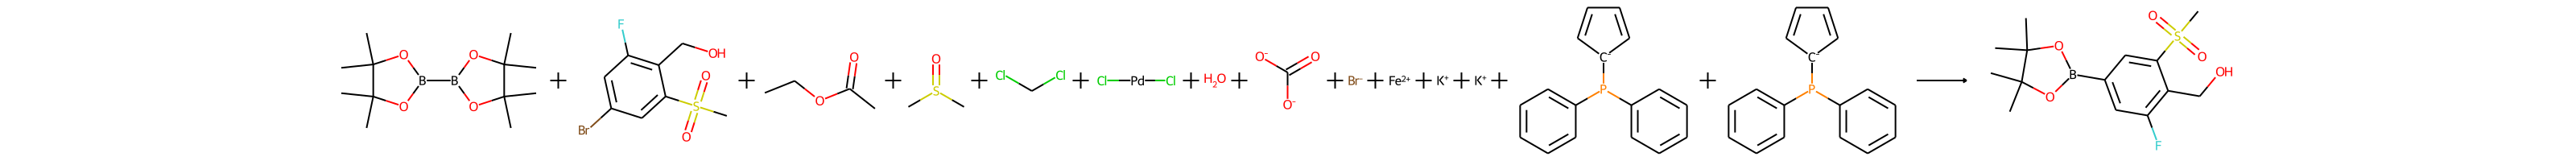

In [24]:
rxn1 = Reactions.ReactionFromSmarts(smiles1, useSmiles=True)
print(data['target'].values[index[1]], data['t5'].values[index[1]], data['Our'].values[index[1]])
Draw.ReactionToImage(rxn1)

57.70000076293945 74.64423370361328 65.57676696777344


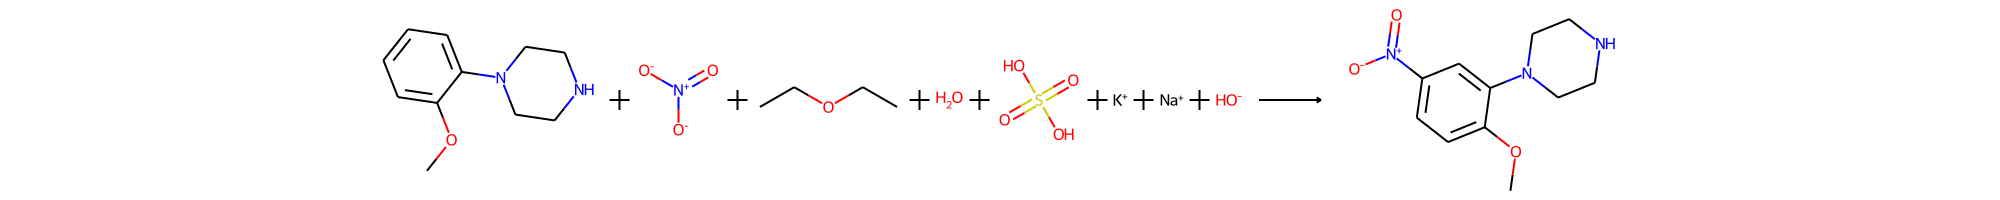

In [25]:
index = [118,119]
smiles3 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles4 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn3 = Reactions.ReactionFromSmarts(smiles3, useSmiles=True)
print(data['target'].values[index[0]], data['t5'].values[index[0]], data['Our'].values[index[0]])
Draw.ReactionToImage(rxn3)


42.0 83.54802703857422 58.15954208374024


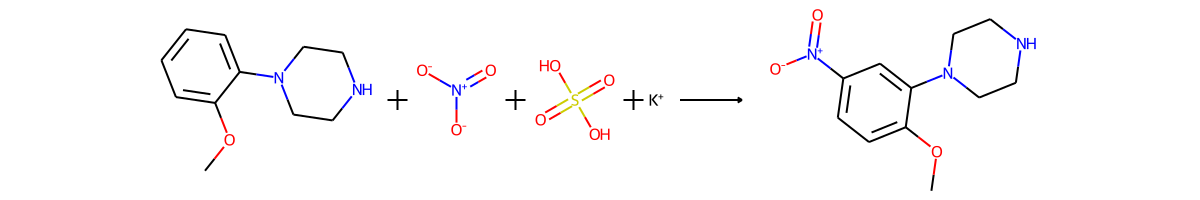

In [26]:
print(data['target'].values[index[1]], data['t5'].values[index[1]], data['Our'].values[index[1]])
rxn4 = Reactions.ReactionFromSmarts(smiles4, useSmiles=True)
Draw.ReactionToImage(rxn4)

86.5999984741211 94.91363525390624 84.158394


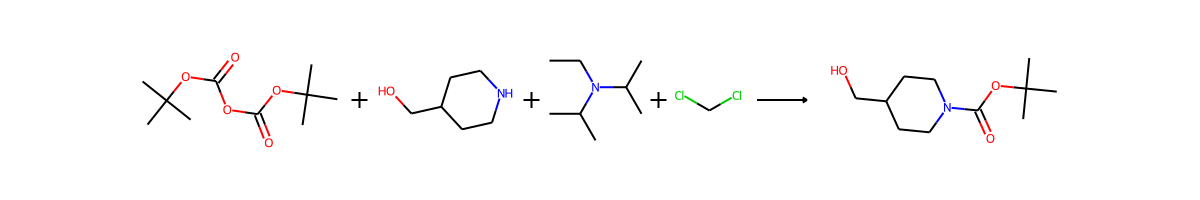

In [21]:
index = [64,65]
smiles5 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles6 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn5 = Reactions.ReactionFromSmarts(smiles5, useSmiles=True)
print(data['target'].values[index[0]], data['t5'].values[index[0]], data['Our'].values[index[0]])
Draw.ReactionToImage(rxn5)


75.0 95.1848373413086 77.3679


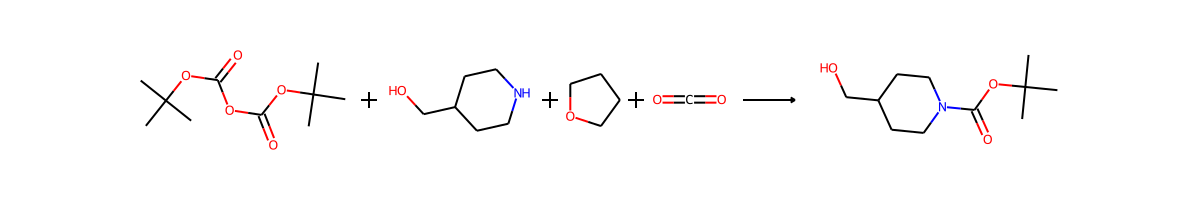

In [22]:
print(data['target'].values[index[1]], data['t5'].values[index[1]], data['Our'].values[index[1]])
rxn6 = Reactions.ReactionFromSmarts(smiles6, useSmiles=True)
Draw.ReactionToImage(rxn6)

57.70000076293945 74.64423370361328 70.84139


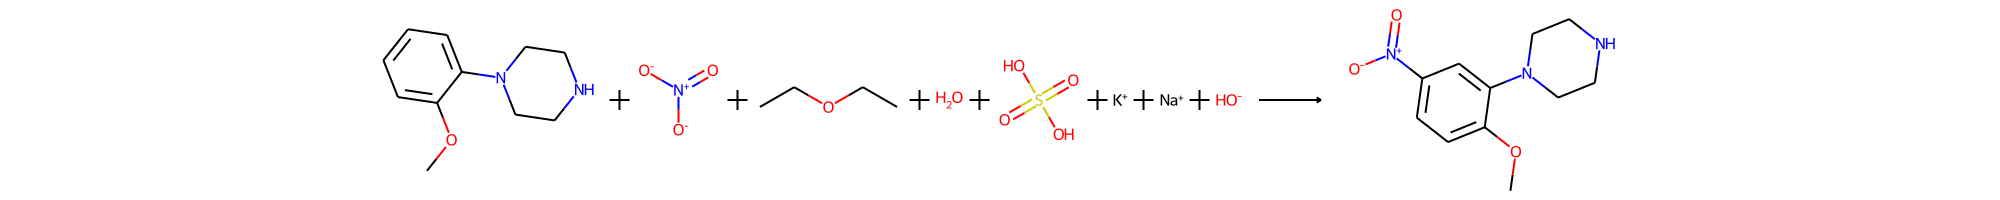

In [25]:
index = [118,119]
smiles7 = data['r'].values[index[0]] + '.' + data['a'].values[index[0]] + '>>' + data['p'].values[index[0]]
smiles8 = data['r'].values[index[1]] + '.' + data['a'].values[index[1]] + '>>' + data['p'].values[index[1]]
rxn7 = Reactions.ReactionFromSmarts(smiles7, useSmiles=True)
print(data['target'].values[index[0]], data['t5'].values[index[0]], data['Our'].values[index[0]])
Draw.ReactionToImage(rxn7)


42.0 83.54802703857422 64.375656


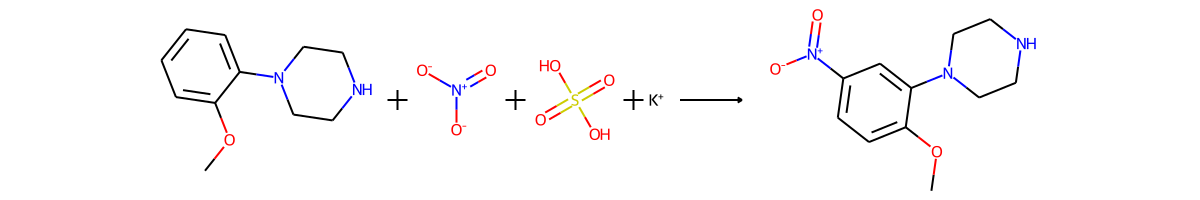

In [26]:
rxn8 = Reactions.ReactionFromSmarts(smiles8, useSmiles=True)
print(data['target'].values[index[1]], data['t5'].values[index[1]], data['Our'].values[index[1]])
Draw.ReactionToImage(rxn8)